In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [63]:
unet = tf.keras.models.load_model('model.h5', compile=False)

image_gray = np.load("D:/fin_de_etude/data/dataset_2d/nodule/image179_slice265.npy")
image_gray = image_gray/255
y_1 = unet.predict(image_gray.reshape((1,512,512,1)))
y_1 = np.where(y_1>0.5,1,0)


1/1 [==============================] - 0s 283ms/step


In [64]:
deeplab = tf.keras.models.load_model('deeplabv3plus.h5', compile=False)

y_2 = deeplab.predict(image_gray.reshape((1,512,512,1)))
y_2 = np.where(y_1>0.5,1,0)



1/1 [==============================] - 1s 1s/step


In [65]:
print(image_gray.max())

1.0


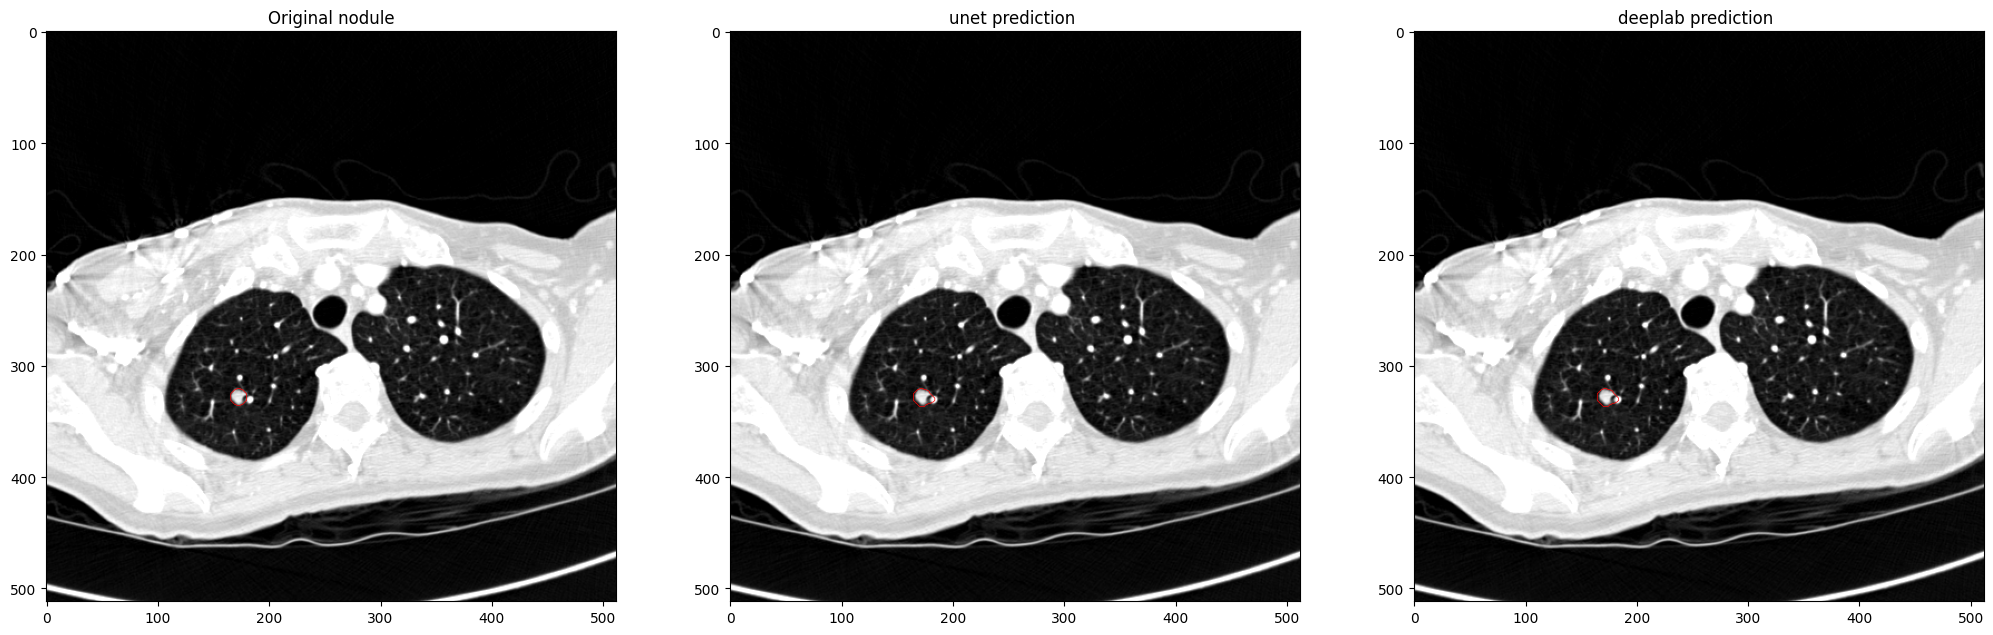

In [66]:
image_gray = image_gray*255
mask = np.load("D:/fin_de_etude/data/nodule_mask/nodule/image179_slice265.npy")
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(25, 25))
ax1.imshow(image_gray,cmap="gray" )
ax1.set_title('Original nodule')
ax2.imshow(image_gray,cmap='gray')
ax2.set_title('unet prediction ')
ax3.imshow(image_gray,cmap='gray')
ax3.set_title('deeplab prediction ')
ax1.contour(mask.reshape((512,512)), levels=[0.4], colors='r', linewidths=0.5)
ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=0.5)
ax3.contour(y_2.reshape((512,512)), levels=[0.4], colors='r', linewidths=0.5)

plt.show()

In [67]:
import numpy as np
from skimage import measure
import cv2
import pandas as ad

  
# take the first contour
# Find contours in the mask
contours = measure.find_contours(mask, 0.85
                                 )

# Loop through the contours and extract the circle properties
for cnt in contours:
    # Convert the contour to integer format
    cnt = np.array(cnt,dtype=np.float32)

    # Fit a circle to the contour using the minimum enclosing circle method
    (y, x), radius = cv2.minEnclosingCircle(cnt)
    center = (x,y)
    diameter = radius*2
    
    # Print the circle properties
    
    print('Center:', center)
    print('Diameter:', diameter)

Center: (172.5, 328.0)
Diameter: 14.611485481262207


In [68]:
df = ad.read_csv("D:/fin_de_etude/data/pfe/data preprocessing/annotation_2.csv")
df = df[df["seriesuid"]=="image179_slice265"]
x,y,z,d = np.double(df["coordX"]),float(df["coordY"]),float(df["coordZ"]),float(df["diameter_mm"])
print(x,y,z,d)
print(df)

172.5271898722807 328.07880172238595 265.9187236 14.629298181389474
   Unnamed: 0          seriesuid     coordX      coordY      coordZ  \
3           3  image179_slice265  172.52719  328.078802  265.918724   

   diameter_mm  
3    14.629298  


In [71]:
import numpy as np
from skimage import measure
import cv2
import pandas as ad

  
# take the first contour
# Find contours in the mask
contours = measure.find_contours(y_2.reshape((512,512)), 0.85
                                 )

# Loop through the contours and extract the circle properties
for cnt in contours:
    # Convert the contour to integer format
    cnt = np.array(cnt,dtype=np.float32)

    # Fit a circle to the contour using the minimum enclosing circle method
    (y, x), radius = cv2.minEnclosingCircle(cnt)
    center = (x,y)
    diameter = radius*2
    
    # Print the circle properties
    
    print('Center:', center)
    print('Diameter:', diameter)

Center: (174.0, 328.0)
Diameter: 19.25869369506836


In [45]:
def calculate_center_diameter(mask):
    nonzero_indices = np.nonzero(mask)
    if len(nonzero_indices[0]) == 0:
        return None, None
    
    x = np.mean(nonzero_indices[0])
    y = np.mean(nonzero_indices[1])
    
    max_dist = np.max(np.sqrt((nonzero_indices[0] - x)**2 + np.abs(nonzero_indices[1] - y)**2))
    diameter = 2 * max_dist
    
    return (x, y), diameter

In [46]:
calculate_center_diameter(mask)

((264.0, 414.0), 8.94427190999916)

In [70]:
import os
import SimpleITK as sitk
import numpy as np
masks = []
images = []
data_dir = "D:/fin_de_etude/data/NSCLC-Radiomics/"  # Root directory containing subfolders with images and masks

# Traverse through the data directory and its subfolders
for folder_name in os.listdir(data_dir):
    folder_path1 = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path1):
        for folder_name in os.listdir(folder_path1):
            folder_path2 = os.path.join(folder_path1, folder_name)

            # Check if the item in the directory is a subfolder
            for folder_name in os.listdir(folder_path2):
                    folder_path = os.path.join(folder_path2, folder_name)
                    try:
                        if "1-1.dcm" in os.listdir(folder_path):
                            image_path = os.path.join(folder_path, "1-1.dcm") 
                            image = sitk.ReadImage(image_path)
                            image_array = sitk.GetArrayFromImage(image)
                            print("Image Shape:", image_array.shape)
                            images.append(image_array)
                            masks.append(mask_array)
                            if "Segmentation" in os.path.basename(folder_path): 
                                mask_path = os.path.join(folder_path, "1-1.dcm")    # Update with the actual mask file namemask = sitk.ReadImage(mask_path)
                                mask_array = sitk.GetArrayFromImage(mask)
                                masks.append(mask_array)
                                print("Mask Shape:", mask_array.shape)
                            # Perform further processing or visualization as needed
                            # ...

                            # Example: Display the shape of image and mask
                            
                    except Exception as e:
                    # Handle the exception or error
                            print( str(e))

Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO reader for "D:/fin_de_etude/data/NSCLC-Radiomics/LUNG1-001\09-18-2008-StudyID-NA-69331\3.000000-NA-78236\1-1.dcm"
Image Shape: (536, 512, 512)
Mask Shape: (774, 512, 512)
Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO reader for "D:/fin_de_etude/data/NSCLC-Radiomics/LUNG1-002\01-01-2014-StudyID-NA-85095\300.000000-Segmentation-5.421\1-1.dcm"
Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO reader for "D:/fin_de_etude/data/NSCLC-Radiomics/LUNG1-002\01-01-2014-StudyID-NA-85095\4.000000-NA-45931\1-1.dcm"
Image Shape: (642, 512, 512)
Mask Shape: (774, 512, 512)
Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkIm

In [71]:
print(len(images))

6


In [72]:
print(len(masks))

12


In [19]:
mask = masks[0]
mask_slice = []
for i in range(mask.shape[0]):
    if mask[i].any()>0:
        mask_slice.append(mask[i])

In [80]:
print(len(mask_slice))
li = masks[0][100:110]

279


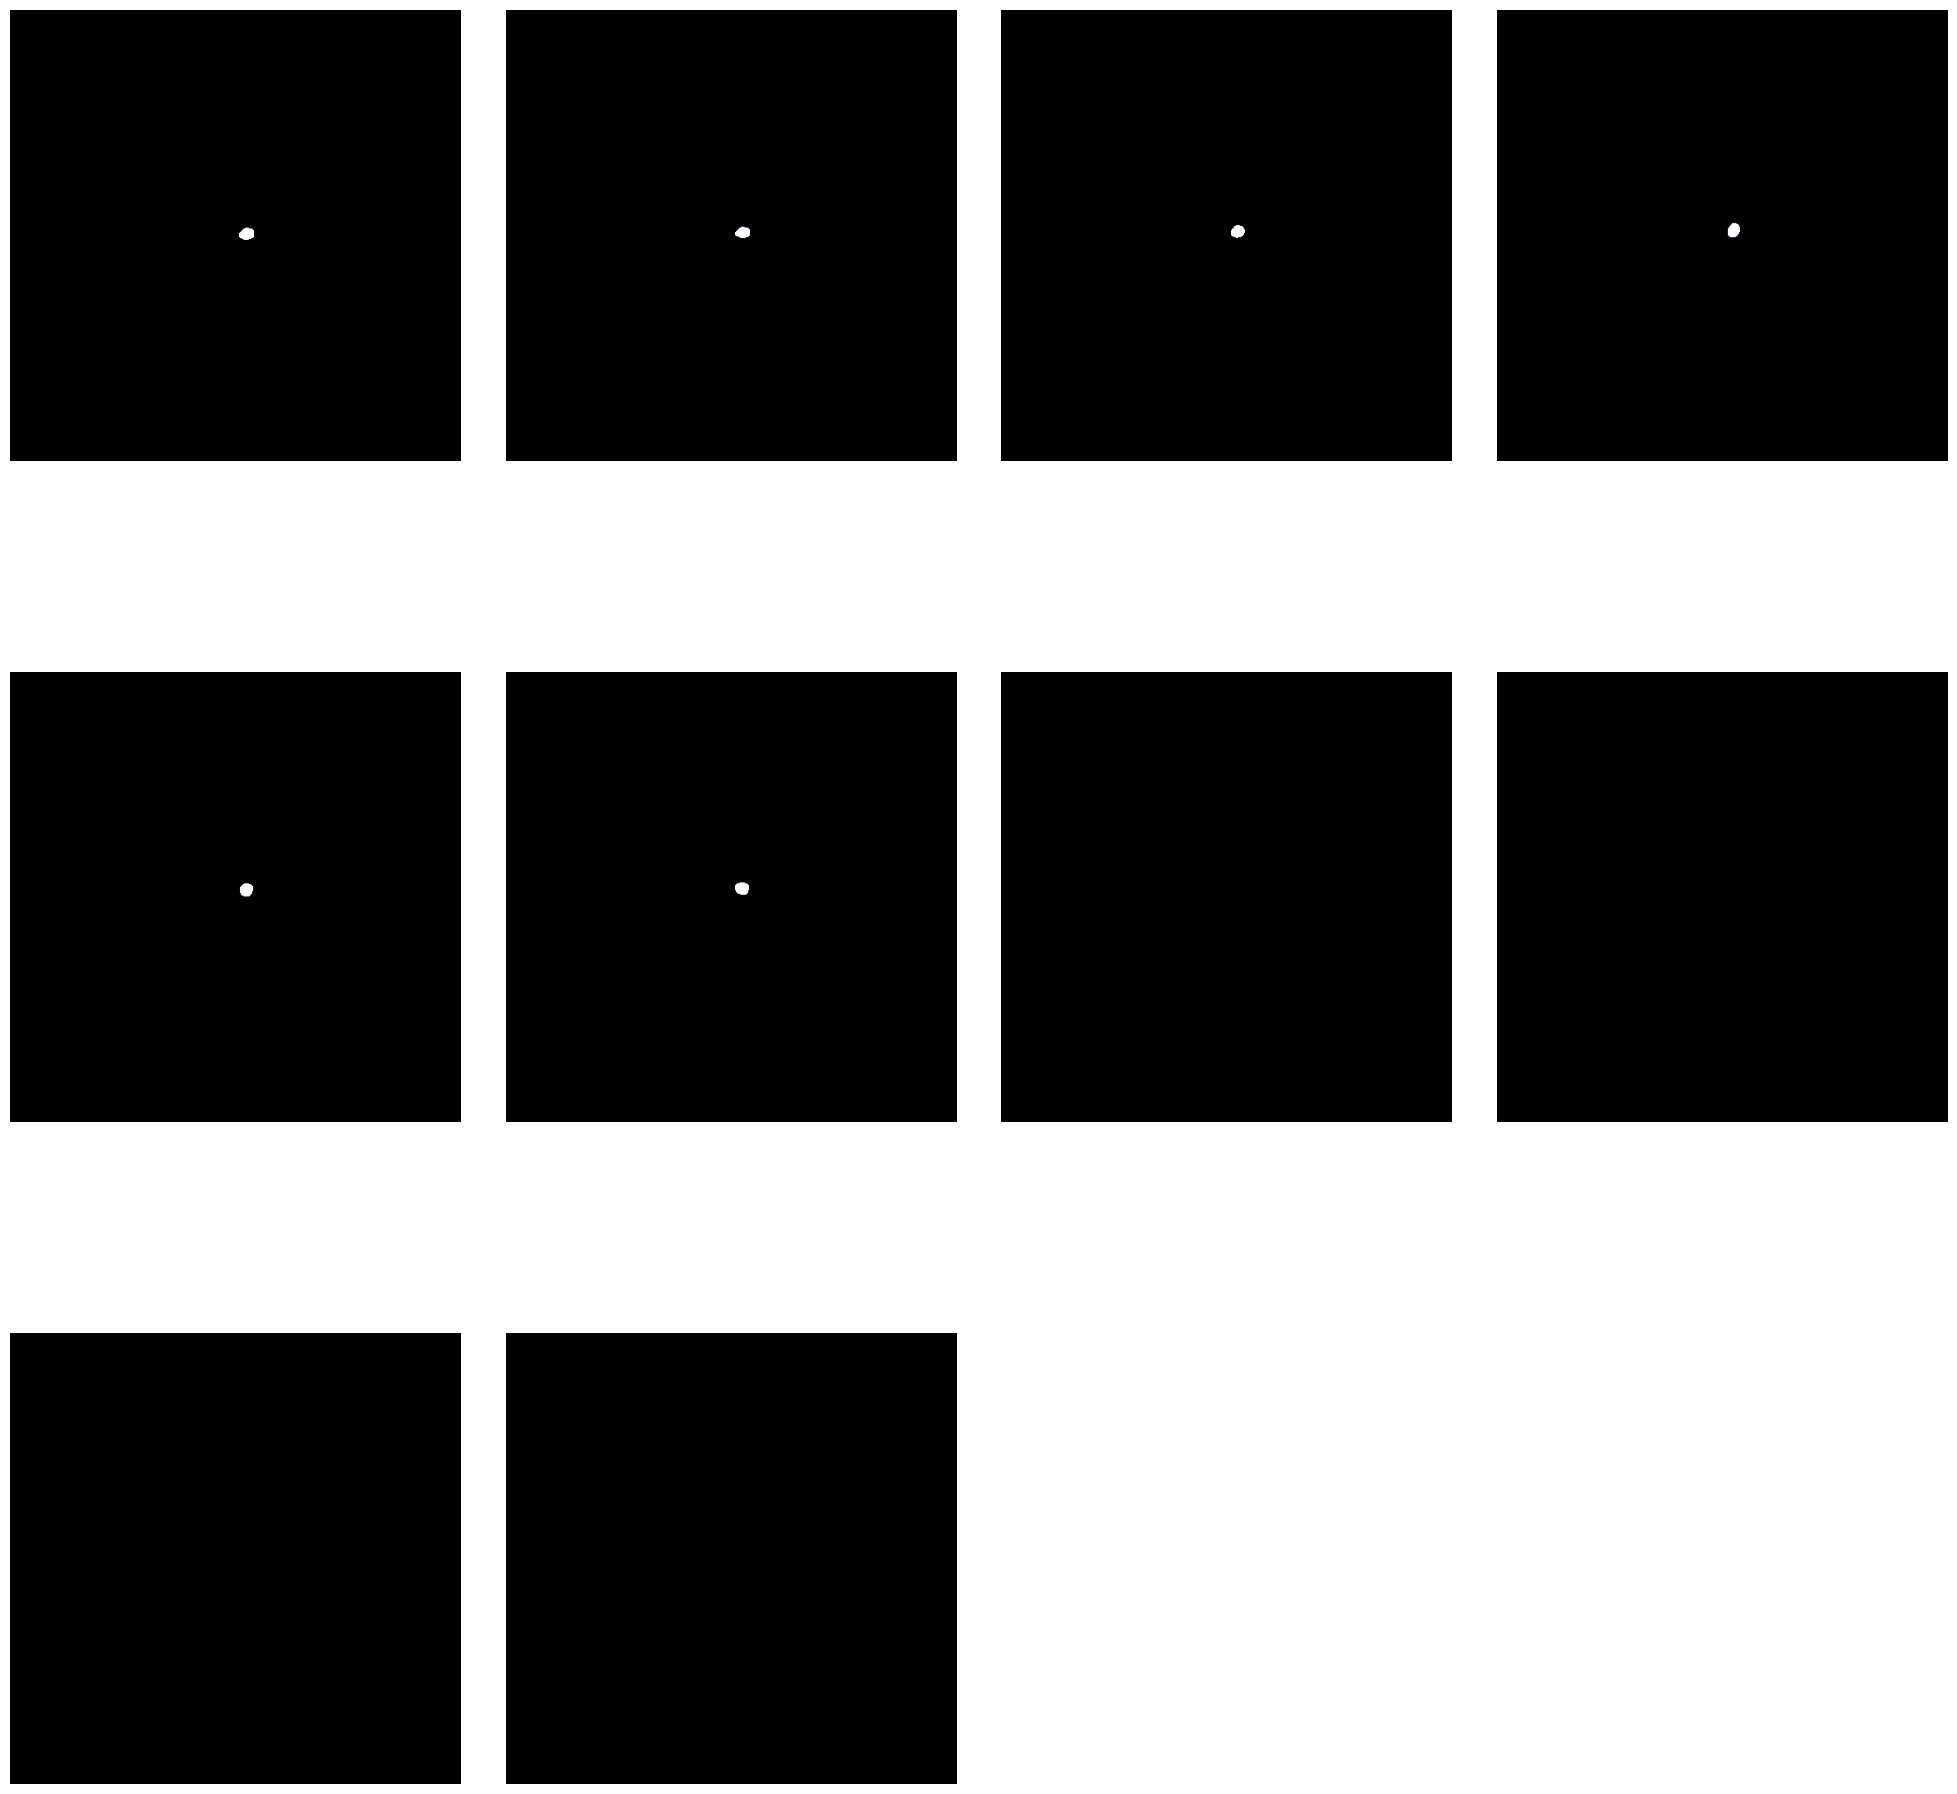

In [81]:
import matplotlib.pyplot as plt
n_samples=len(li)
num_cols = int(np.ceil(np.sqrt(n_samples)))
num_rows = int(np.ceil(n_samples / num_cols))
fig = plt.figure(figsize=(25, 25))
i = 0
for img in li:
    
    axs =   fig.add_subplot(
                                    num_rows, num_cols,  1+i)
    axs.axis('off')
    axs.imshow(img,cmap=plt.cm.bone)
        
            
    i+=1
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Show the plot
plt.show()

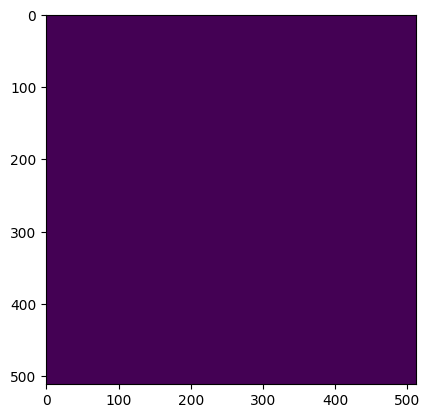

In [76]:
li = images[0][100:110]

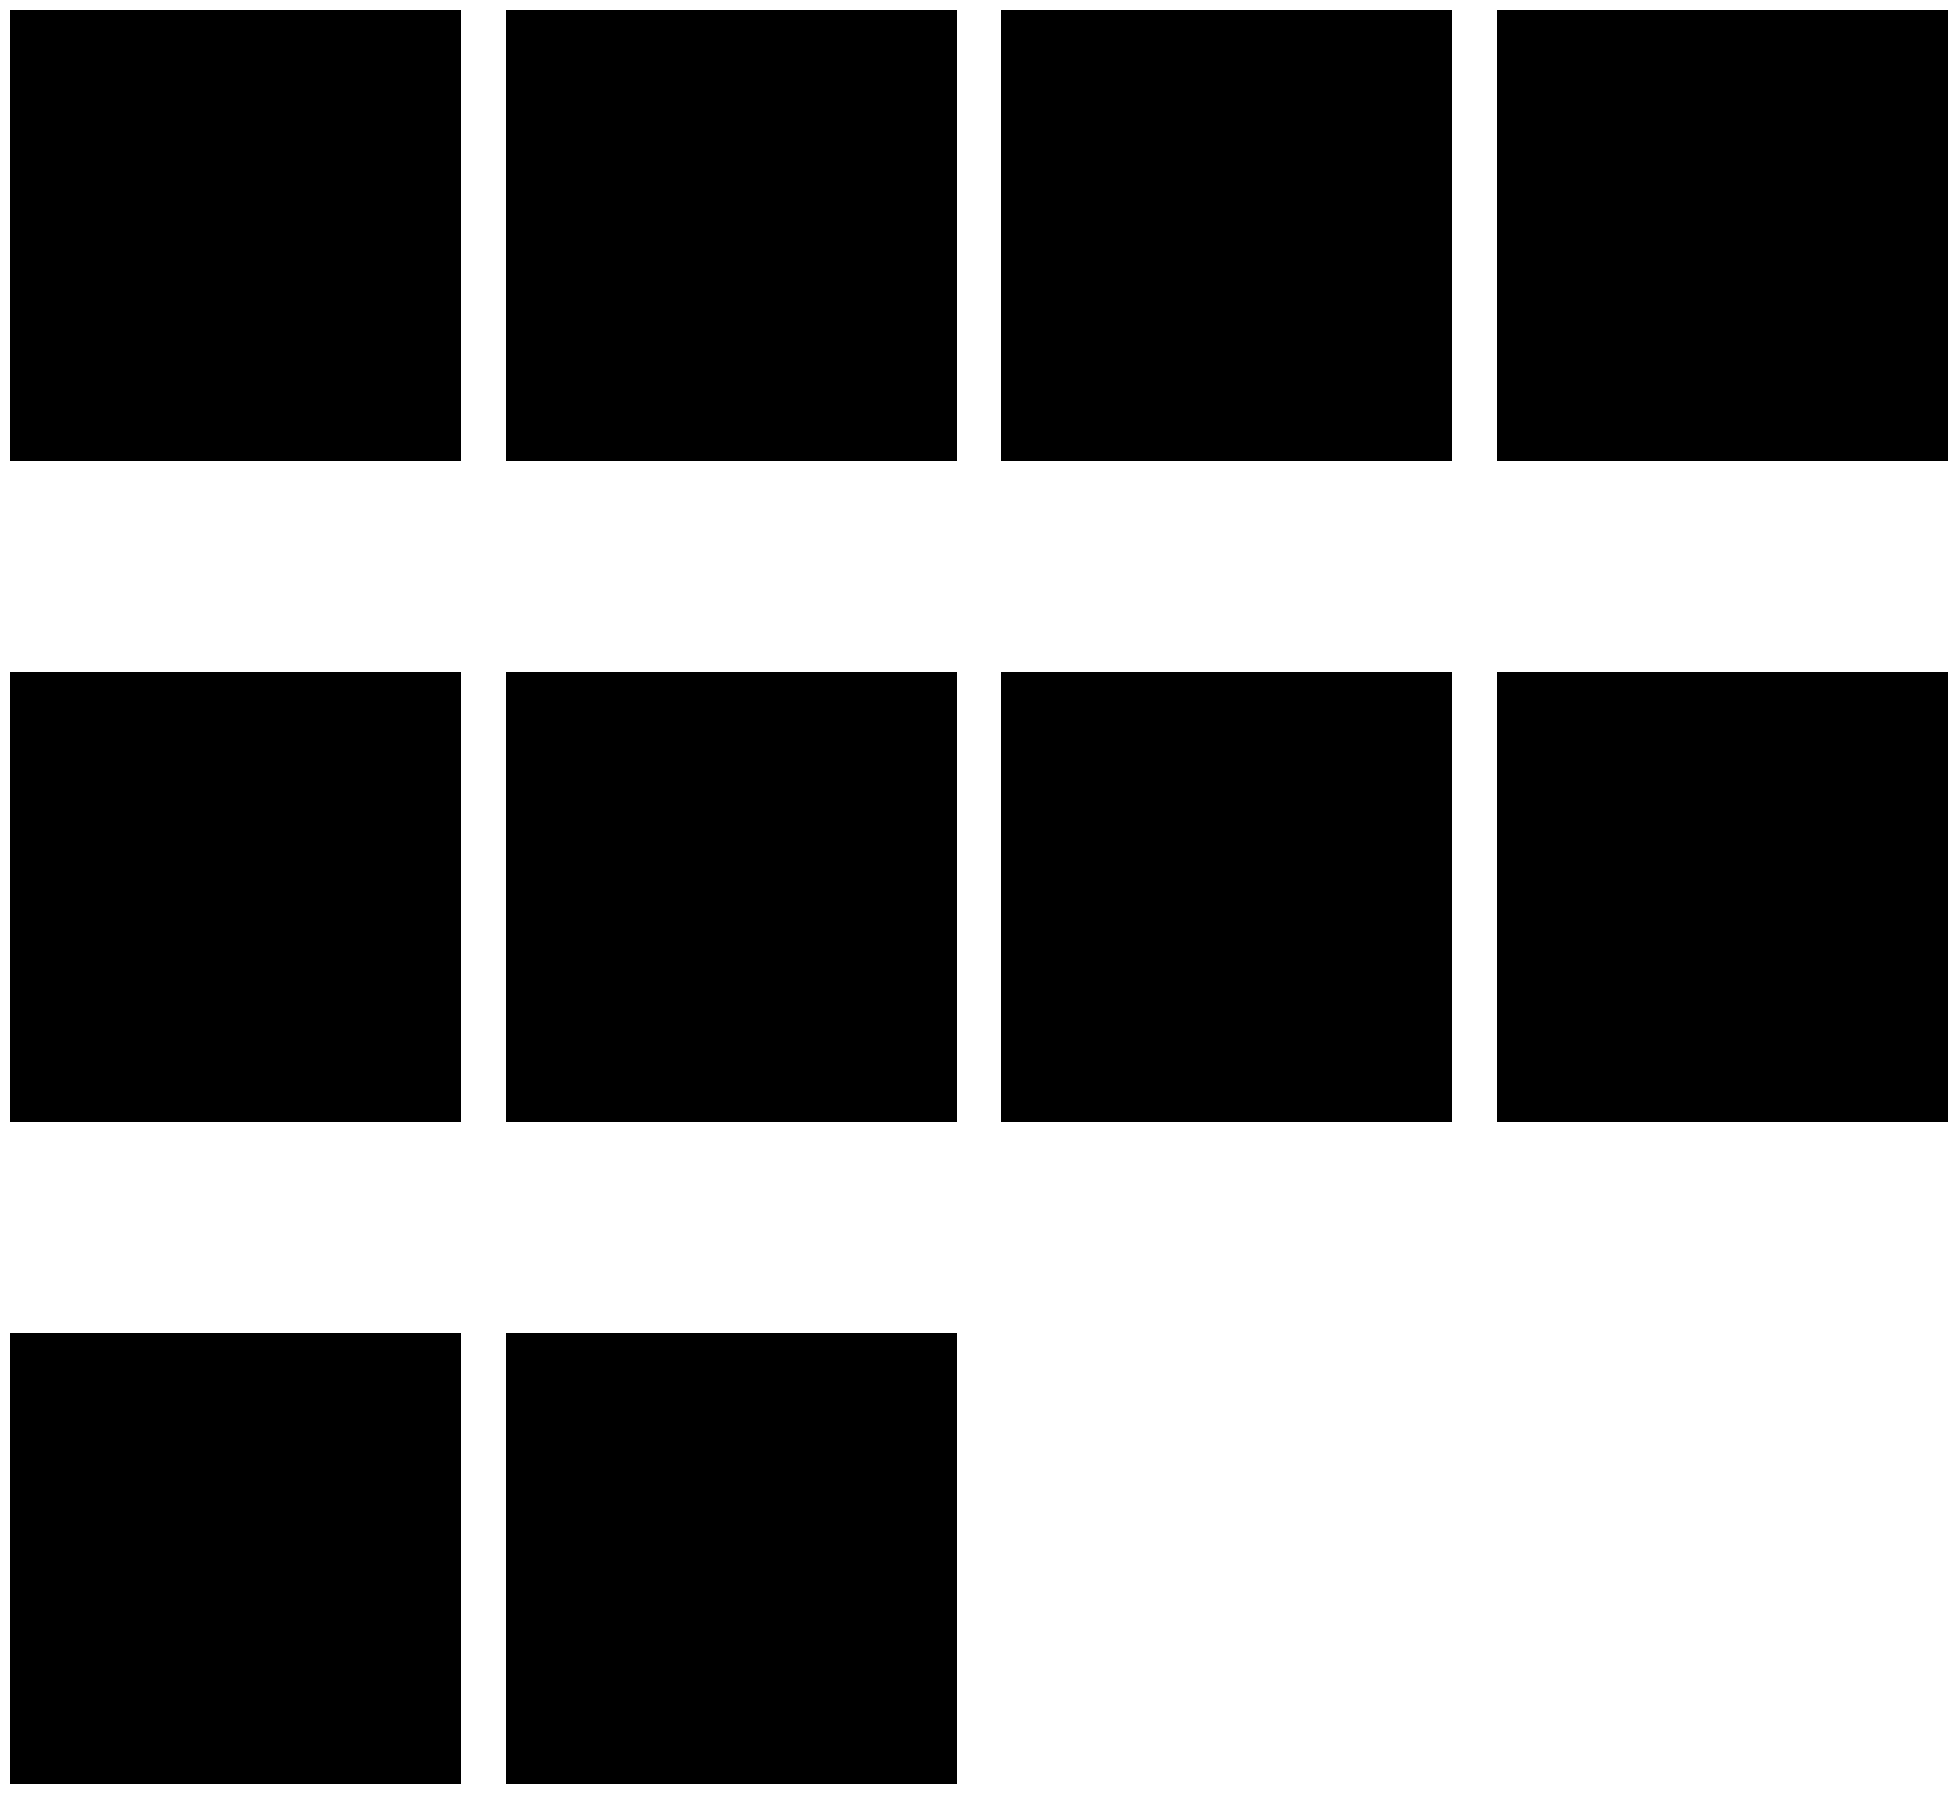

In [77]:
import matplotlib.pyplot as plt
n_samples=len(li)
num_cols = int(np.ceil(np.sqrt(n_samples)))
num_rows = int(np.ceil(n_samples / num_cols))
fig = plt.figure(figsize=(25, 25))
i = 0
for img in li:
    
    axs =   fig.add_subplot(
                                    num_rows, num_cols,  1+i)
    axs.axis('off')
    axs.imshow(img,cmap=plt.cm.bone)
        
            
    i+=1
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Show the plot
plt.show()